# Distilling a Random Forest with a single DecisionTree

On HackerNews there was a topic discussed at some point about ways to distill knowledge from a complex (almost black box) large tree ensamble (a RandomForest with lots of sub-trees was used as an example).

You would like to do this for multiple resones, but one of them is model exaplainability, so a way to understand how that complex model behaves so you can draw conclusions and improve it (or guard against its failures).

One comment really caught my eye:

> An alternative is to re-lable data with the ensemble's outputs and then learn a decision tree over that. ([source](https://news.ycombinator.com/item?id=25121998))


This post is my attempt of testing this strategy out.


# Get a dataset

I'll first use a clean and small dataset not to make things to complicated.

In [141]:
from sklearn.datasets import load_iris
import pandas as pd

dataset = load_iris()
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Then I'm going to split this dataset into a training set (random 70% of the data) and a test set (the other 15% of the data).

In [142]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3)
df_train.shape, df_test.shape, df_train.shape[0] / (df_train.shape[0] + df_test.shape[0])

((105, 5), (45, 5), 0.7)

## Train a Random Forest model

And then I'm going to train a `RandomForestClassifier` that will solve this problem. I'm not going to be too concerned on the model performence (so I'm not going to really make it generalize well) because I'm really more interested in achieving the same behaviour (either good or bad as it is) with a `DecisionTree` proxy. 

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
rf.fit(df_train.drop(columns='target'), df_train['target'])

print(classification_report(df_test['target'], rf.predict(df_test.drop(columns='target'))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



## Retraining a single decision tree that would approximate the RandomForest

> An alternative is to re-lable data with the ensemble's outputs and then learn a decision tree over that. ([source](https://news.ycombinator.com/item?id=25121998))



What this actually means is doing the following steps:
* Train a large, complex ensamble (the RandomForest model above)
* Take **all the data** (including the test set) and add the predictions to it (even for the test set)
* Overfitt a single DecisionTree over the **all the data** but training on the predictions of the RandomForests.

What this basically does is creating a single DecisionTree that can predict exactly the same stuff as the RandomForest. We know that a `DecisionTree` has the ability to overfitt perfectly the training data if it is allowed to (for example, if we leave it to grow until leaf nodes contain only one datapoint).

In [144]:
def __inp(df, exclude_columns=['target']):
    return df.drop(columns=list(set(exclude_columns) & set(df.columns)))

def __out(df, target_column='target'):
    return df[target_column]

def relable(df, model):
    df = df.copy()
    df['relabel'] = model.predict(__inp(df))
    return df

# relable everything
df_train_tree = relable(df_train, rf)
df_test_tree = relable(df_test, rf)
df_tree = relable(df, rf)

df_train_tree.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,relabel
97,6.2,2.9,4.3,1.3,1,1
114,5.8,2.8,5.1,2.4,2,2
125,7.2,3.2,6.0,1.8,2,2
110,6.5,3.2,5.1,2.0,2,2
113,5.7,2.5,5.0,2.0,2,2


We *want* to overfit the training data with the decision tree because what we are actually looking for is a single condensed tree that behaves exactly the same as the original `RandomForest`. And we want the DecisionTree to behave **exactly** the same as the RandomForest on the test data as well. That's why we train on the full dataset here.

In [145]:
from sklearn.tree import DecisionTreeClassifier
from functools import partial
from sklearn.metrics import f1_score

__inp = partial(__inp, exclude_columns=['target', 'relabel'])
__rel = partial(__out, target_column='relabel')
__f1_score = partial(f1_score, average="macro")


dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_impurity_split=0)
dt.fit(__inp(df_tree), __rel(df_tree))

print(f"This should show that we've completely overfitted the relables (i.e. F1 score == 1.0). \nSo we've mimiked the RandomForest's behaviour perfectly!")
print(classification_report(__rel(df_train_tree), dt.predict(__inp(df_train_tree))))
assert __f1_score(__rel(df_train_tree), dt.predict(__inp(df_train_tree))) == 1.0

print("\n\n")
print(f"This shows the performance on the actual `target` values of the test set (never seen).")
print(classification_report(__out(df_test_tree), dt.predict(__inp(df_test_tree))))
assert __f1_score(__out(df_test), rf.predict(__inp(df_test_tree))) == __f1_score(__out(df_test), dt.predict(__inp(df_test_tree)))

This should show that we've completely overfitted the relables (i.e. F1 score == 1.0). 
So we've mimiked the RandomForest's behaviour perfectly!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        36

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




This shows the performance on the actual `target` values of the test set (never seen).
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


So this did work, we have a `DecisionTree` that behaves exactly as the `RandomForest`. The only problem is that this applies only on the seen data (so it may be possible that the RandomForest generalises well on new / other data, but the DecisionTree will not, because it is a perfect aproximator trained only on the data available at that moment of training). We will test this in the following section.

Neverthless, what tree did we got?

In [146]:
!apt-get update; apt-get -y install graphviz
!pip install dtreeviz

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
grap

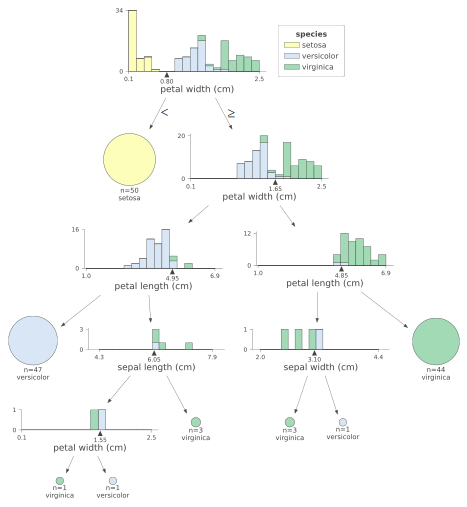

In [147]:
from dtreeviz.trees import *
viz = dtreeviz(dt, 
               __inp(df_tree),
               __out(df_tree),
               target_name='species',
               feature_names=__inp(df_test_tree).columns, 
               class_names=dataset.target_names.tolist()
              )
viz

## Does this aproximation hold for unseen data?

As I've said before, the only problem is that this strategy applies strictly only on the seen/available data (so it may be possible that the RandomForest generalisez well on new / other data, but the DecisionTree will not, because it is a perfect aproximator trained only on the data available at that moment of training).

To thest this out we will do a three-way split, leaving the third unseen to the DecitionTree and we will replicate the experiment above

In [148]:
from sklearn.model_selection import train_test_split

df_train, df_rest = train_test_split(df, test_size=0.3)
df_test, df_future = train_test_split(df_rest, test_size=0.5)
df_all = pd.concat((df_train, df_test))

df_train.shape, df_test.shape,  df_future.shape, df_test.shape[0] / (df_train.shape[0] + df_test.shape[0] + df_future.shape[0])

((105, 5), (22, 5), (23, 5), 0.14666666666666667)

We now have:
* `df_train` - 70% of the data
* `df_test` - 15% of the data
* `df_all` = `df_train + df_test`
* `df_future` - 15% of (simulated) future data

In [149]:
# train a "generizable" RandomForest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
rf.fit(__inp(df_train), __out(df_train))

print(f"RandomForest performance:")
print(classification_report(__out(df_test), rf.predict(__inp(df_test))))

# relable **current** data
df_train_tree = relable(df_train, rf)
df_test_tree = relable(df_test, rf)
df_tree = relable(df_all, rf)

# train DecisionTree aproximator
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_impurity_split=0)
dt.fit(__inp(df_tree), __rel(df_tree))

print("\n\n")
print(f"This should show that we've completely overfitted the predictions (i.e. F1 score == 1.0). \nSo we've mimiked the RandomForest's behaviour perfectly!")
print(classification_report(__rel(df_train_tree), dt.predict(__inp(df_train_tree))))
assert __f1_score(__rel(df_train_tree), dt.predict(__inp(df_train_tree))) == 1.0

print("\n\n")
print(f"This shows the performance on the actual `target` values of the test set and \nthat they are equal to the performance of the RandomForest model on the same data.")
print(classification_report(__out(df_test_tree), dt.predict(__inp(df_test_tree))))
assert __f1_score(__out(df_test), rf.predict(__inp(df_test_tree))) == __f1_score(__out(df_test), dt.predict(__inp(df_test_tree)))

RandomForest performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22




This should show that we've completely overfitted the predictions (i.e. F1 score == 1.0). 
So we've mimiked the RandomForest's behaviour perfectly!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        35

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105




This shows the performance on the actual `target` values o

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


Let's see how we do on the future data now!

In [150]:
print("Random Forest performance on future data:")
print(classification_report(__out(df_future), rf.predict(__inp(df_future))))

print("DecisionTree aproximator on future data")
print(classification_report(__out(df_future), dt.predict(__inp(df_future))))

Random Forest performance on future data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.82      0.90        11
           2       0.80      1.00      0.89         8

    accuracy                           0.91        23
   macro avg       0.93      0.94      0.93        23
weighted avg       0.93      0.91      0.91        23

DecisionTree aproximator on future data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.82      0.90        11
           2       0.80      1.00      0.89         8

    accuracy                           0.91        23
   macro avg       0.93      0.94      0.93        23
weighted avg       0.93      0.91      0.91        23



From the performance of the two models above, you can see that they indeed reach the same performance (quite surprisingly I would say).

Now, the code above is **not** determinstic so if you run all the cells from the beggining up until this point multiple times, you will see that the `RandomForest` has a different accuracy each time. 

Having said that, this particular comparision that we are interested (the performance of the `RandomForest` on the future data, compared on the perfirmance of the `DecisionTree` aproximator in the future data) is **almost** always the same. Almost (9 ot of 10), but not **always**. I've seen ocasional runs where the `RandomForest` outperformed slightly the `DecisionTree`.

# Using a more challenging dataset

The [iris dataset](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) is a [toy dataset](https://scikit-learn.org/stable/datasets/index.html#toy-datasets) from scikit-learn because it has only 150 datapoints and very few lables.

To thest the above approach more thoroughly we need to use a more [plausible dataset](https://scikit-learn.org/stable/datasets/index.html#real-world-datasets) (still for classification, to keep things consistent) with lots more features and datapoints.

For this we've choosen the [forest covertype dataset](https://scikit-learn.org/stable/datasets/index.html#forest-covertypes) where we have 581012 datapoints, each with 54 features describing some 30x30m measurements of a plot of land. We need to predict the correct category of vegetation for each plot.



In [151]:
from sklearn.datasets import fetch_covtype 
import pandas as pd

dataset = fetch_covtype()
df = pd.DataFrame(data=dataset.data, columns=["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points", "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"])
df['target'] = dataset.target

df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,target
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


We will again save a `future` dataset for later use.

In [152]:
from sklearn.model_selection import train_test_split

df_train, df_rest = train_test_split(df, test_size=0.3)
df_test, df_future = train_test_split(df_rest, test_size=0.5)
df_all = pd.concat((df_train, df_test))

df_train.shape, df_test.shape,  df_future.shape, df_test.shape[0] / (df_train.shape[0] + df_test.shape[0] + df_future.shape[0])

((406708, 55), (87152, 55), (87152, 55), 0.1500003442269695)

In [153]:
# train a "generizable" RandomForest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
rf.fit(__inp(df_train), __out(df_train))

print(f"RandomForest performance:")
print(classification_report(__out(df_test), rf.predict(__inp(df_test))))

# relable **current** data
df_train_tree = relable(df_train, rf)
df_test_tree = relable(df_test, rf)
df_tree = relable(df_all, rf)

# train DecisionTree aproximator
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_impurity_split=0)
dt.fit(__inp(df_tree), __rel(df_tree))

print("\n\n")
print(f"This should show that we've completely overfitted the predictions (i.e. F1 score == 1.0). \nSo we've mimiked the RandomForest's behaviour perfectly!")
print(classification_report(__rel(df_train_tree), dt.predict(__inp(df_train_tree))))
assert __f1_score(__rel(df_train_tree), dt.predict(__inp(df_train_tree))) == 1.0

print("\n\n")
print(f"This shows the performance on the actual `target` values of the test set and \nthat they are equal to the performance of the RandomForest model on the same data.")
print(classification_report(__out(df_test_tree), dt.predict(__inp(df_test_tree))))
assert __f1_score(__out(df_test), rf.predict(__inp(df_test_tree))) == __f1_score(__out(df_test), dt.predict(__inp(df_test_tree)))

RandomForest performance:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.64      0.74      0.69     31900
           2       0.71      0.76      0.74     42493
           3       0.62      0.65      0.63      5254
           4       0.00      0.00      0.00       414
           5       0.00      0.00      0.00      1397
           6       0.00      0.00      0.00      2673
           7       0.00      0.00      0.00      3021

    accuracy                           0.68     87152
   macro avg       0.28      0.31      0.29     87152
weighted avg       0.62      0.68      0.65     87152



/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)





This should show that we've completely overfitted the predictions (i.e. F1 score == 1.0). 
So we've mimiked the RandomForest's behaviour perfectly!
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    169056
           2       1.00      1.00      1.00    211823
           3       1.00      1.00      1.00     25829

    accuracy                           1.00    406708
   macro avg       1.00      1.00      1.00    406708
weighted avg       1.00      1.00      1.00    406708




This shows the performance on the actual `target` values of the test set and 
that they are equal to the performance of the RandomForest model on the same data.
              precision    recall  f1-score   support

           1       0.64      0.74      0.69     31900
           2       0.71      0.76      0.74     42493
           3       0.62      0.65      0.63      5254
           4       0.00      0.00      0.00       414
           5       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now that we have everything prepared, let's just test what happens with the two models on this more plausible dataset.

In [154]:
print("Random Forest performance on future data:")
print(classification_report(__out(df_future), rf.predict(__inp(df_future))))

print("DecisionTree aproximator on future data")
print(classification_report(__out(df_future), dt.predict(__inp(df_future))))

Random Forest performance on future data:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.65      0.74      0.69     31869
           2       0.72      0.76      0.74     42488
           3       0.62      0.64      0.63      5331
           4       0.00      0.00      0.00       402
           5       0.00      0.00      0.00      1389
           6       0.00      0.00      0.00      2597
           7       0.00      0.00      0.00      3076

    accuracy                           0.68     87152
   macro avg       0.28      0.31      0.29     87152
weighted avg       0.62      0.68      0.65     87152

DecisionTree aproximator on future data
              precision    recall  f1-score   support

           1       0.65      0.74      0.69     31869
           2       0.72      0.76      0.74     42488
           3       0.62      0.64      0.63      5331
           4       0.00      0.00      0.00       402
           5       0.00      0.00      0.00      1389
           6       0.00      0.00     

Again, we have exactly the same performance so this seems to work OK, but..

## Is this generalizable to other tree-ensamble methods, like XGBoost?

We will train a XGBoost model and try to reproduce the results above with it so see if is possible to distill the XGBoost model into a single decision tree.

We will use the same `covtype` dataset since it's large and tune the training and instantiation of the model to obtain a nice performant model. While in the previous experiment we didn't really bother optimising the model, it is possible that a great generalizable model will show some differences when applying this process.

In [82]:
from sklearn.datasets import fetch_covtype 
import pandas as pd

dataset = fetch_covtype()
df = pd.DataFrame(data=dataset.data, columns=["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points", "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9", "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29", "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"])
df['target'] = dataset.target

df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,target
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [89]:
from sklearn.model_selection import train_test_split

df_train, df_rest = train_test_split(df, test_size=0.3)
df_test, df_future = train_test_split(df_rest, test_size=0.5)
df_all = pd.concat((df_train, df_test))

df_train.shape, df_test.shape,  df_future.shape, df_test.shape[0] / (df_train.shape[0] + df_test.shape[0] + df_future.shape[0])

((406708, 55), (87152, 55), (87152, 55), 0.1500003442269695)

In [96]:
from xgboost import XGBClassifier

# train a "generizable" RandomForest
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=20, 
    n_jobs=-1, 
    verbosity=1, 
    booster='gbtree',
    objective='mlogloss',
    # num_class=len(np.unique(__out(df)))
)

xgb.fit(
    X=__inp(df_train), 
    y=__out(df_train), 
    verbose=True, 
    eval_set=[(__inp(df_test), __out(df_test))],
    eval_metric=['mlogloss'],
    early_stopping_rounds=4,
)

print(f"XGBoost performance:")
print(classification_report(__out(df_test), xgb.predict(__inp(df_test))))

# relable **current** data
df_train_tree = relable(df_train, xgb)
df_test_tree = relable(df_test, xgb)
df_tree = relable(df_all, xgb)

# train DecisionTree aproximator
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_impurity_split=0)
dt.fit(__inp(df_tree), __rel(df_tree))

print("\n\n")
print(f"This should show that we've completely overfitted the predictions (i.e. F1 score == 1.0). \nSo we've mimiked the RandomForest's behaviour perfectly!")
print(classification_report(__rel(df_train_tree), dt.predict(__inp(df_train_tree))))
assert __f1_score(__rel(df_train_tree), dt.predict(__inp(df_train_tree))) == 1.0

print("\n\n")
print(f"This shows the performance on the actual `target` values of the test set and \nthat they are equal to the performance of the RandomForest model on the same data.")
print(classification_report(__out(df_test_tree), dt.predict(__inp(df_test_tree))))
assert __f1_score(__out(df_test), xgb.predict(__inp(df_test_tree))) == __f1_score(__out(df_test), dt.predict(__inp(df_test_tree)))

[0]	validation_0-mlogloss:1.76519
Will train until validation_0-mlogloss hasn't improved in 4 rounds.
[1]	validation_0-mlogloss:1.62483
[2]	validation_0-mlogloss:1.50959
[3]	validation_0-mlogloss:1.41254
[4]	validation_0-mlogloss:1.32897
[5]	validation_0-mlogloss:1.25724
[6]	validation_0-mlogloss:1.19438
[7]	validation_0-mlogloss:1.13841
[8]	validation_0-mlogloss:1.08877
[9]	validation_0-mlogloss:1.04369
[10]	validation_0-mlogloss:1.00364
[11]	validation_0-mlogloss:0.967579
[12]	validation_0-mlogloss:0.934488
[13]	validation_0-mlogloss:0.905293
[14]	validation_0-mlogloss:0.878637
[15]	validation_0-mlogloss:0.854214
[16]	validation_0-mlogloss:0.831893
[17]	validation_0-mlogloss:0.81107
[18]	validation_0-mlogloss:0.792415
[19]	validation_0-mlogloss:0.77495
[20]	validation_0-mlogloss:0.759048
[21]	validation_0-mlogloss:0.744567
[22]	validation_0-mlogloss:0.731076
[23]	validation_0-mlogloss:0.718687
[24]	validation_0-mlogloss:0.707045
[25]	validation_0-mlogloss:0.695962
[26]	validation_0-m

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)





This should show that we've completely overfitted the predictions (i.e. F1 score == 1.0). 
So we've mimiked the RandomForest's behaviour perfectly!
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    145591
           2       1.00      1.00      1.00    210335
           3       1.00      1.00      1.00     28306
           4       1.00      1.00      1.00      1826
           5       1.00      1.00      1.00      1975
           6       1.00      1.00      1.00      6585
           7       1.00      1.00      1.00     12090

    accuracy                           1.00    406708
   macro avg       1.00      1.00      1.00    406708
weighted avg       1.00      1.00      1.00    406708




This shows the performance on the actual `target` values of the test set and 
that they are equal to the performance of the RandomForest model on the same data.
              precision    recall  f1-score   support

           1       0.78      0.77

In [97]:
print("XGBoost performance on future data:")
print(classification_report(__out(df_future), xgb.predict(__inp(df_future))))

print("DecisionTree aproximator on future data")
print(classification_report(__out(df_future), dt.predict(__inp(df_future))))

XGBoost performance on future data:
              precision    recall  f1-score   support

           1       0.78      0.76      0.77     31881
           2       0.79      0.84      0.82     42520
           3       0.76      0.86      0.81      5326
           4       0.85      0.73      0.79       421
           5       0.82      0.23      0.35      1358
           6       0.70      0.38      0.49      2623
           7       0.88      0.74      0.80      3023

    accuracy                           0.79     87152
   macro avg       0.80      0.65      0.69     87152
weighted avg       0.79      0.79      0.78     87152

DecisionTree aproximator on future data
              precision    recall  f1-score   support

           1       0.78      0.76      0.77     31881
           2       0.79      0.84      0.82     42520
           3       0.75      0.86      0.80      5326
           4       0.84      0.73      0.79       421
           5       0.81      0.23      0.36      1358
  

If you look closely then you will see some diffrences in performance between the two, but overall they seem pretty close actually!

# Conclusions

Yes, it seems plausible that you can indeed aproximate a tree ensamble (either a RandomForest or an XGBoost - and most likely a GradientBoostedTree or a LigtGBM model bu I haven't tested these) with into a single tree that you can later inspect and debug. 

There may be some performance drops between the two, but in my experiments, the distillation process *mostly* yielded the same results regardless if it was a XGBoost model or a RandomFores, or if we had a big or small dataset to train on.

One advice I'd give is that if you go on this route you need to actually compare the performance of the two datasets with a fresh dataset (either kept asside from the beggining or gathered anew) because **there is a difference between the two models**.

If you combine this [with model exporting to code](http://www.clungu.com/Converting_a_DecisionTree_into_python_code/), you get quite a nice dependency free deloyment process of a large an powerfull model.

In a future post I'd like to discuss also the GRANT option mentioned in the same HackerNews thread to see how it compares and performs.

>Graft, Reassemble, Answer delta, Neighbour sensitivity, Training delta (GRANT)



You can open this notebook in Colab by using the button bellow:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YDHkVQHhVxS5Kzy-Uxn4UAjP-d3e_Wxp?usp=sharing)
